# How Lensed UMAP works

This notebook demonstrates three approaches for applying lenses to UMAP graphs.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import lensed_umap as lu

from umap import UMAP
import matplotlib.pyplot as plt

## Load data

We use a simple dataset for this demonstration. Each point has a 2D position and a hue-value, shown below. The points form an interesting structure, with one loop and four flares sticking out. Each flare has a hue local minimum and maximum towards its center. These can be separated by applying a lens.

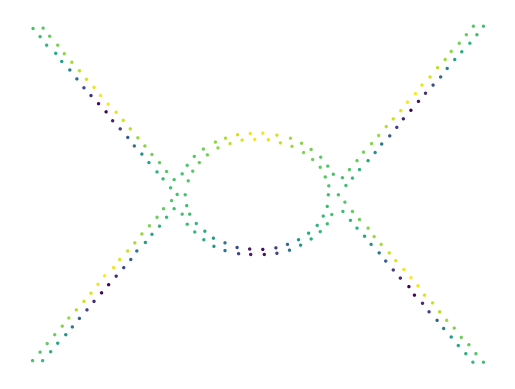

In [3]:
df = pd.read_csv("./data/five_circles.csv", header=0)
lens = np.log(df.hue)

plt.scatter(df.x, df.y, 2, lens, cmap="viridis")
plt.axis("off")
plt.show()

## Default UMAP

Lensed UMAP starts from a normal UMAP model. In some cases, time can be saved by only constructing UMAP's graph and leaving the 2D layout for later. In this example, we reduce the repulsion strength in the 2D layout to ensure the loop remains intact. Otherwise, the process is quite normal.

Constructed graph with 3408 edges


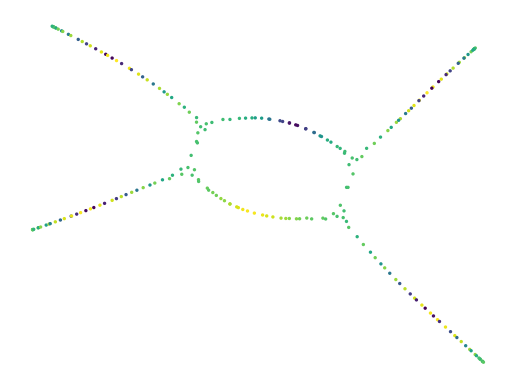

In [4]:
# Construct UMAP graph but don't embed yet
projector = UMAP(
    repulsion_strength=0.1,  # To avoid tears in projection that
    negative_sample_rate=2,  # are not in the modelled graph!
).fit(df[["x", "y"]])

print(f"Constructed graph with {projector.graph_.size} edges")
x, y = lu.extract_embedding(projector)
plt.scatter(x, y, 2, lens, cmap="viridis")
plt.axis("off")
plt.show()

## Global Lens

The first lens-type is a global lens, which is implemented in the `apply_lens` function. This function takes a fitted UMAP object and returns a (shallow) copy of that object with a new `graph_` and `embedding_` attributes. Effectively, the function discretizes the given 1D lens-values into segments. Then, the graph is filtered to keep only those edges whose points lie within one segment or within neighboring segments. Finally, the layout is updated for the new graph.

The cell below demonstrates the function in action. Notice how the four flares became circles, separating the local extrema from each other.

Constructed graph with 2340 edges


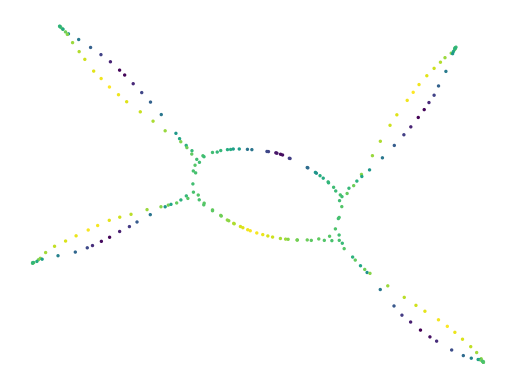

In [5]:
lensed, bins = lu.apply_lens(projector, lens, resolution=6, ret_bins=True)
print(f"Constructed graph with {lensed.graph_.size} edges")
x, y = lu.extract_embedding(lensed)
plt.scatter(x, y, 2, lens, cmap="viridis")
plt.axis("off")
plt.show()

This lens-type supports two kinds discretization strategies: `regular` and `balanced`. Regular is the default and creates equally sized segments. Effectively, this strategy reduces to a global lens-value-difference threshold; removing all edges with a lens-value-difference larger than the one segment width. Balanced creates segments that contain the same number of points (except the last one may be slightly larger than the others). As a consequence, the lens-value-difference threshold varies with the lens-distribution's density: for uncommon lens-values the threshold is higher and for common lens-values the threshold is smaller.

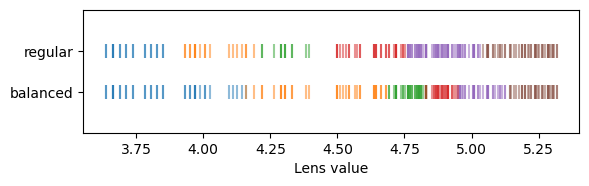

In [6]:
def scatter_segments(projector, lens, y, strategy):
    colors = lu.apply_lens(
        projector,
        lens,
        resolution=6,
        discretization=strategy,
        skip_embedding=True,
        ret_bins=True,
    )[1]
    plt.scatter(
        lens,
        np.repeat(y, len(x)),
        100,
        colors,
        marker="|",
        alpha=0.5,
        cmap="tab10",
        vmin=0,
        vmax=10,
    )


plt.figure()
plt.gcf().set_figheight(plt.gcf().get_figheight() / 3)
scatter_segments(projector, lens, 1, "regular")
scatter_segments(projector, lens, 0, "balanced")
plt.xlabel("Lens value")
plt.ylim([-1, 2])
plt.yticks([0, 1])
plt.gca().set_yticklabels(["balanced", "regular"])
plt.show()

## Global Mask

The second lens-type is a global mask, which is implemented in the `apply_mask` function. This function takes two UMAP models: `projector` and `masker`. Then, it creates a (shallow) copy of `projector` and updates the graph keeping only the edges that also exist in `masker`. This can be seen as an intersection, but the edges keep `projector`'s weights! Finally, the 2D layout is updated for the new graph. To save some compute cost, `masker` can be fitted with `transform_mode="graph"`, which skips the 2D layout step.

Like the balanced global lens, this strategy can be reduced to a lens-density varying lens-distance threshold. Here, that threshold is expressed as the number of neighbours to keep in the lens-dimensions. As a consequence, `masker`'s `n_neighbor` value may need to be quite big to avoid removing too many edges, which can be expensive to compute. Different from the global lens, this strategy is not limited to a 1D lens dimension. Instead it uses anything that UMAP accepts.

Constructed graph with 2576 edges


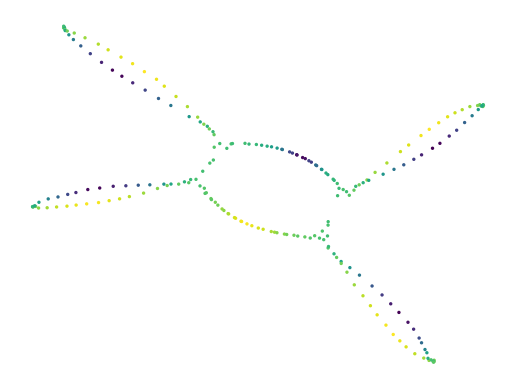

In [7]:
masker = UMAP(n_neighbors=150, transform_mode="graph").fit(df.hue.to_numpy()[None].T)
lensed = lu.apply_mask(projector, masker)
print(f"Constructed graph with {lensed.graph_.size} edges")
x, y = lu.extract_embedding(lensed)
plt.scatter(x, y, 2, lens, cmap="viridis")
plt.axis("off")
plt.show()

## Local Mask

The last lens-type is a local mask, which is implemented in the `apply_local_mask` function. This function takes a UMAP model and returns a (shallow) copy with updated graph and 2D layout. The function first computes a distance in the lens dimensions for each UMAP model's edge. Then, the closest `n_neighbors` edges are kept for each point. Like with the global mask, edges keep their initial weigths. Finally, the 2D layout is updated. 

This strategies does not reduce to a global lens-distance threshold. Instead, the threshold varies with the spread of lens-values accross the initial UMAP manifold. 

This strategy's parameters are quite intuitive. They directly specify how many edges to keep. The other strategies inderectly specify which edges to remove, which can be more difficult to reason about.


Constructed graph with 1360 edges


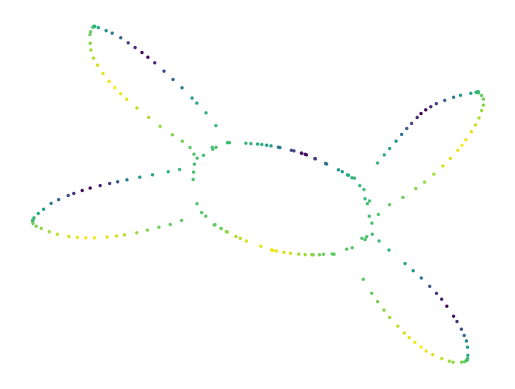

In [8]:
lensed = lu.apply_local_mask(projector, df.hue)
print(f"Constructed graph with {lensed.graph_.size} edges")
x, y = lu.extract_embedding(lensed)
plt.scatter(x, y, 2, lens, cmap="viridis")
plt.axis("off")
plt.show()